# Library Imports

In [2]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='l1_ratio parameter is only used when penalty is.*')


In [ ]:
os.getcwd()

'c:\\Users\\rbrul\\Documents\\GitHub\\DSBA6010\\Final_Project\\Validation_Hat'

## We followed the Starter_Notebook steps so that preprocessing was not included here

In [4]:
loan_df = pd.read_pickle('clean_df_for_eda.pkl')

In [5]:
# Subsetting data to 200k rows
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

In [6]:
num_cols = loan_df.select_dtypes(include=['float64'])

## Outlier detection and removal. Using z-scores to handle outlier removal

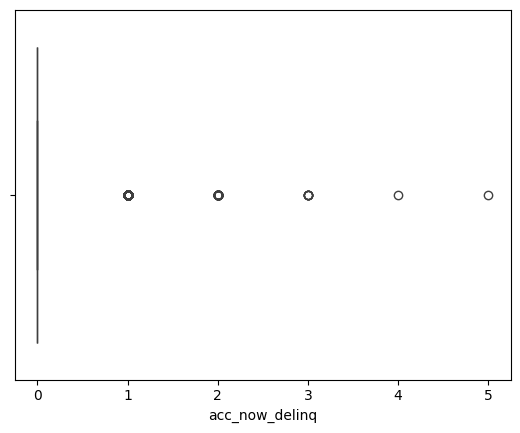

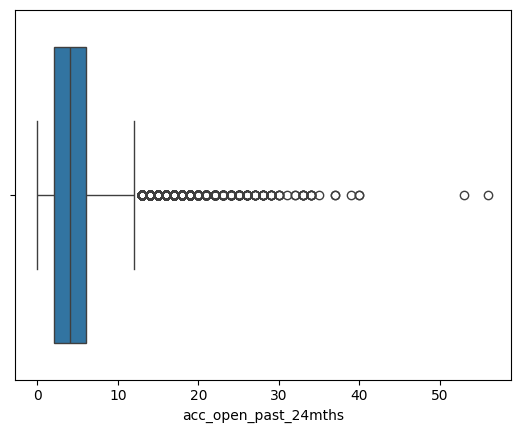

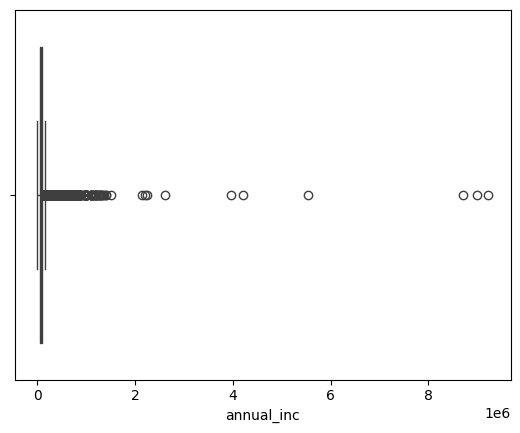

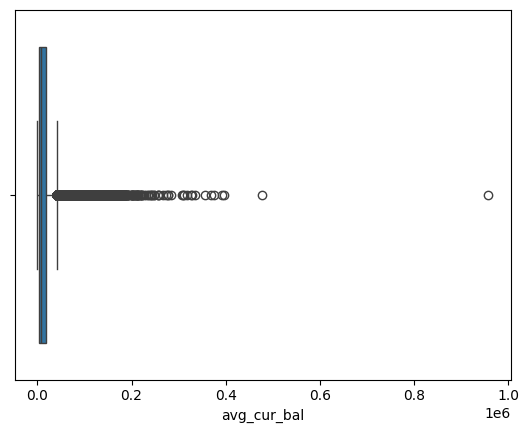

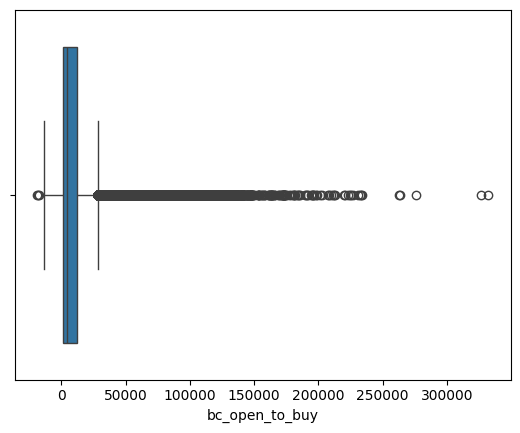

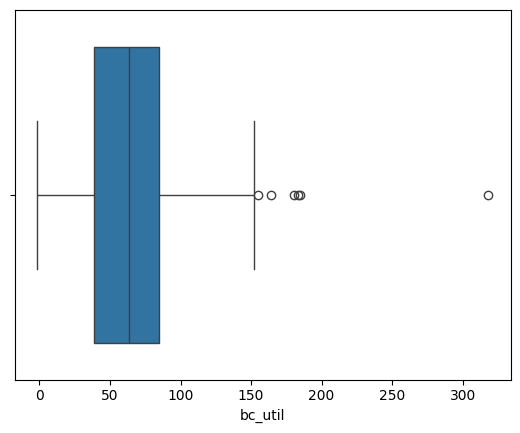

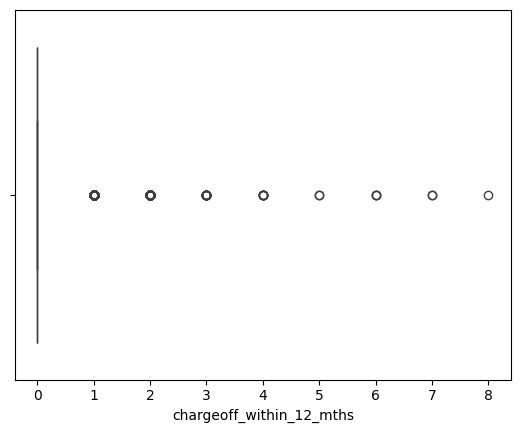

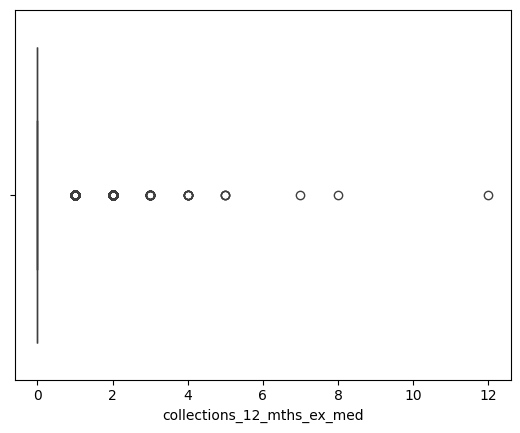

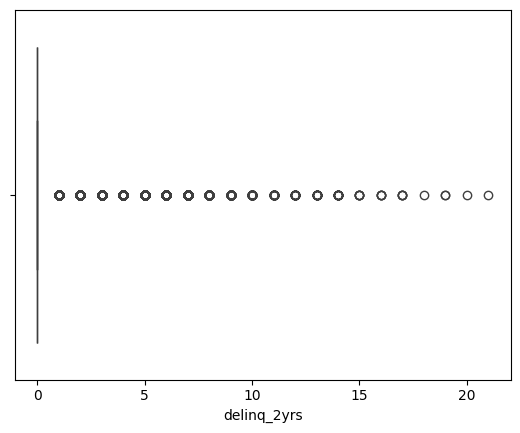

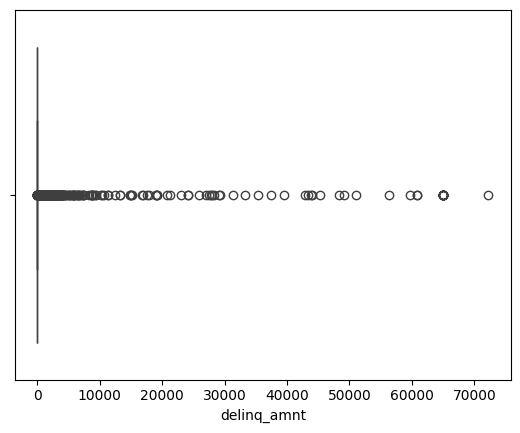

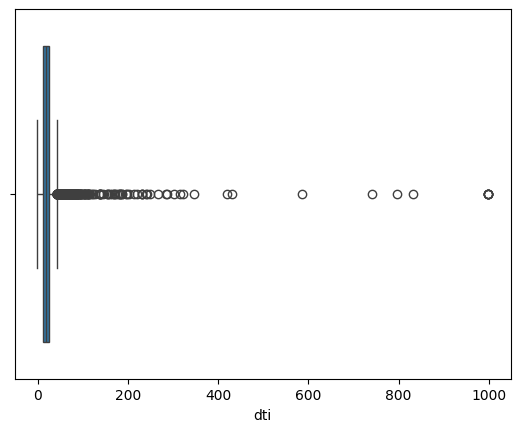

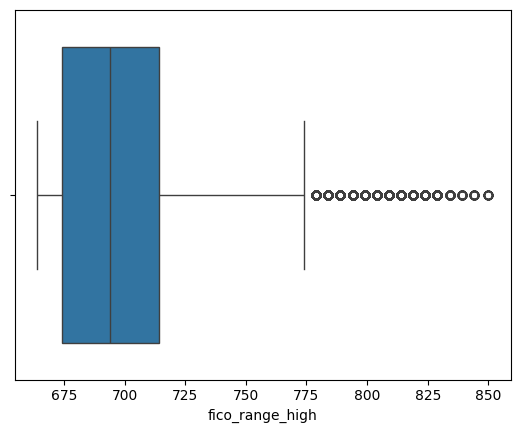

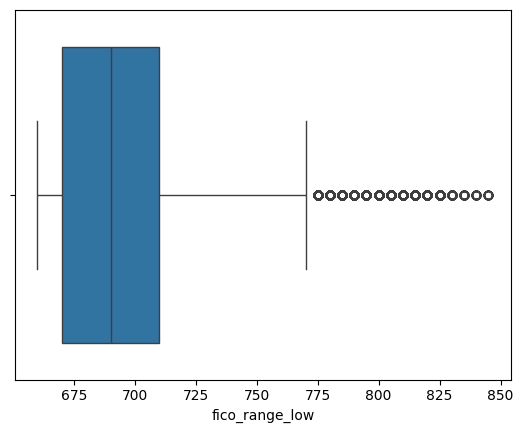

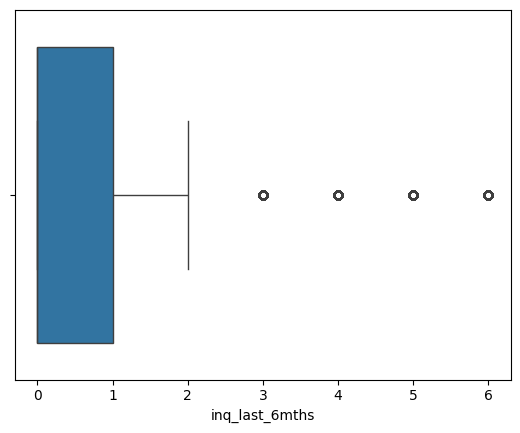

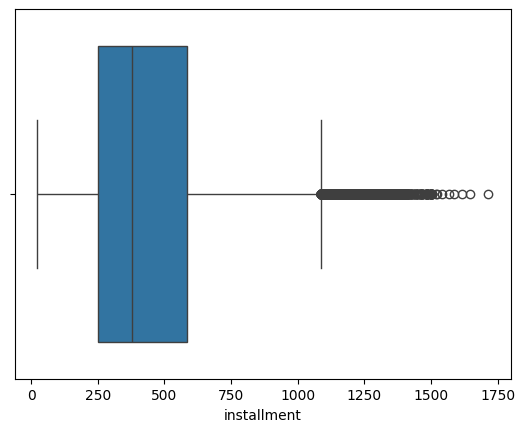

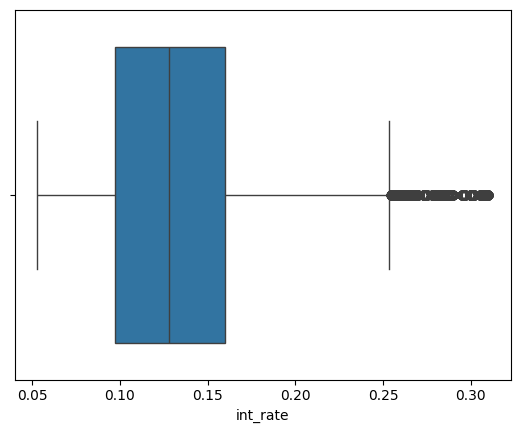

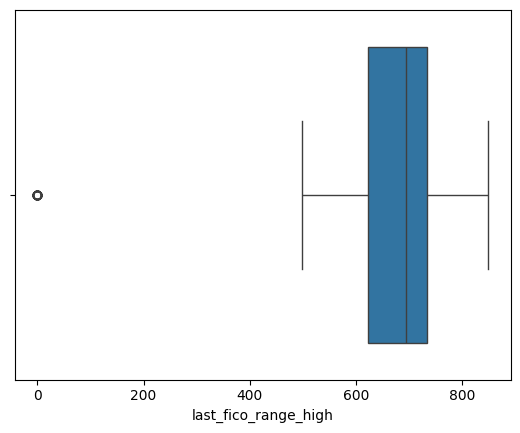

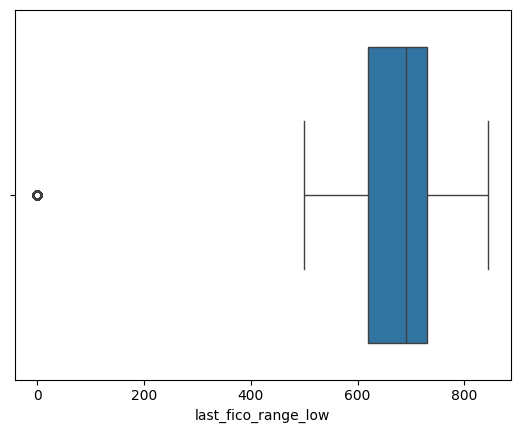

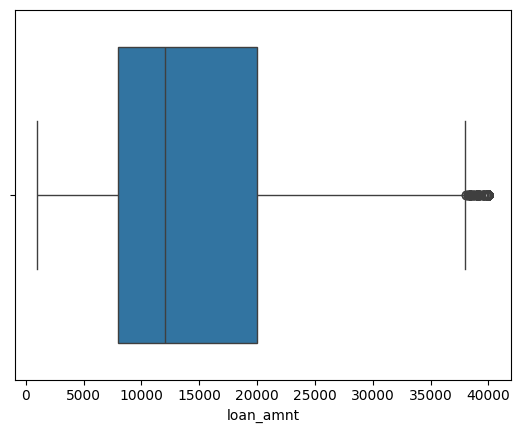

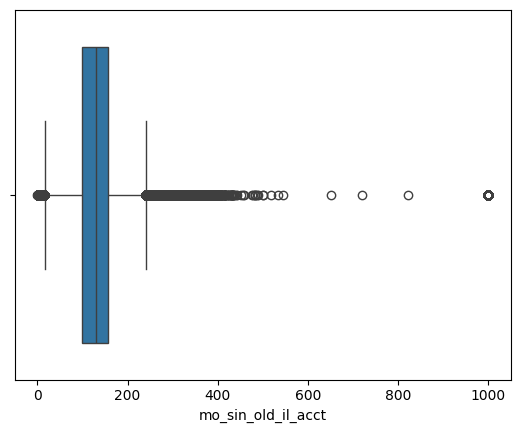

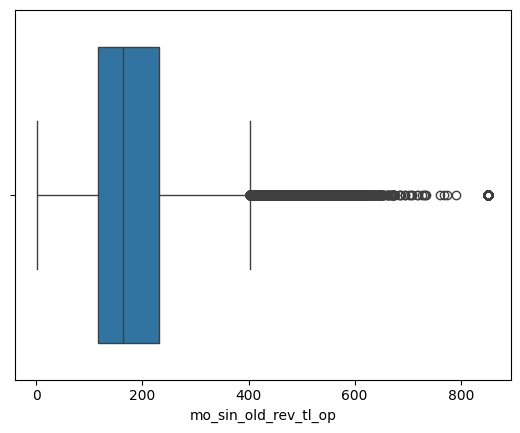

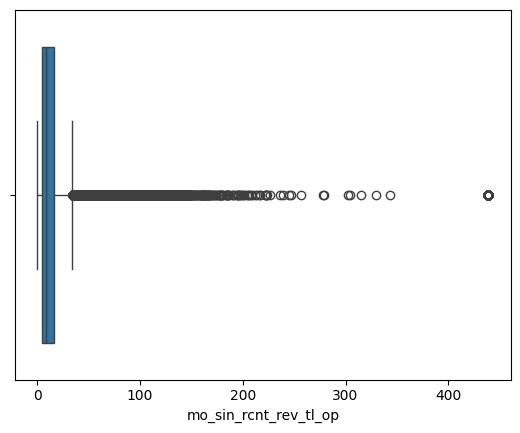

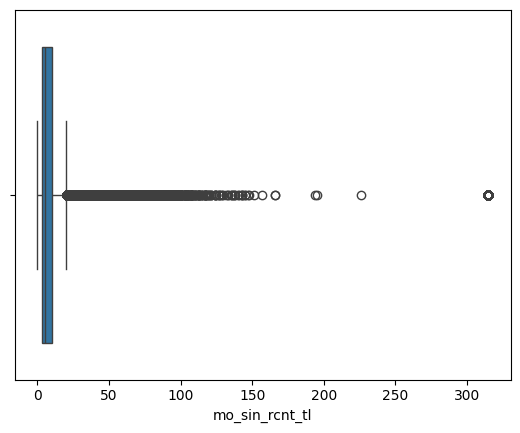

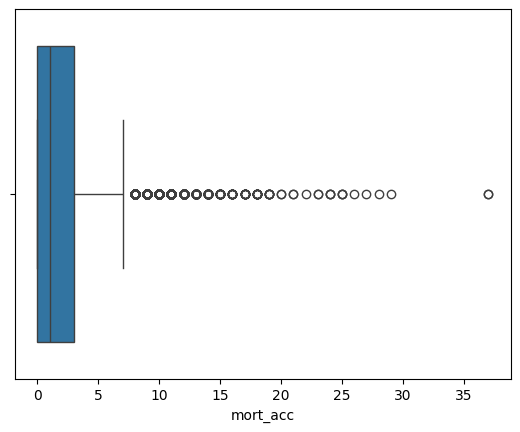

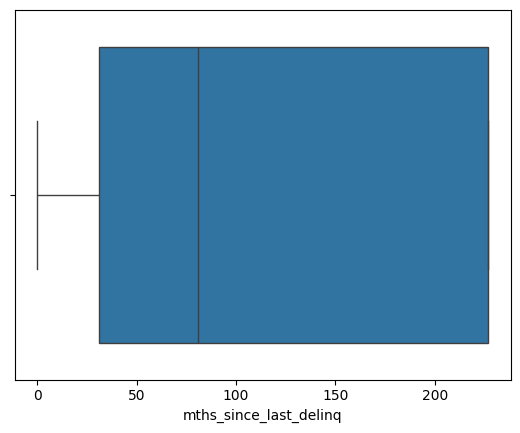

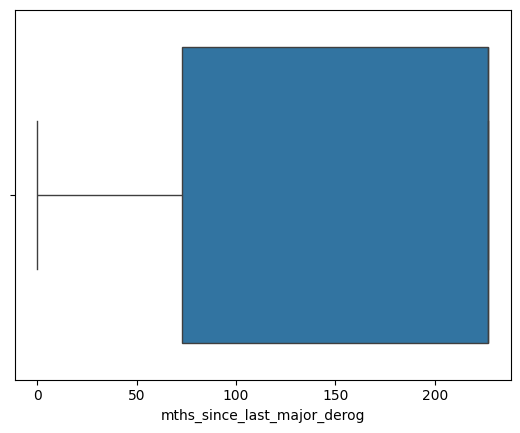

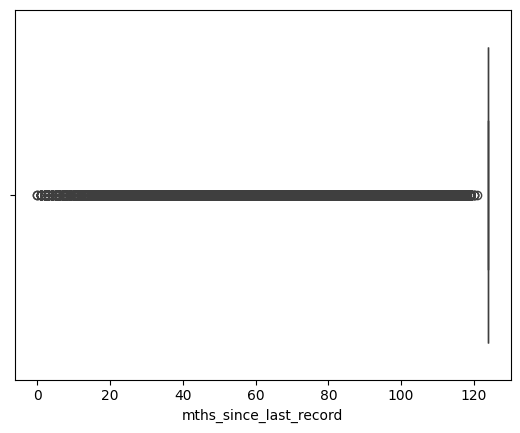

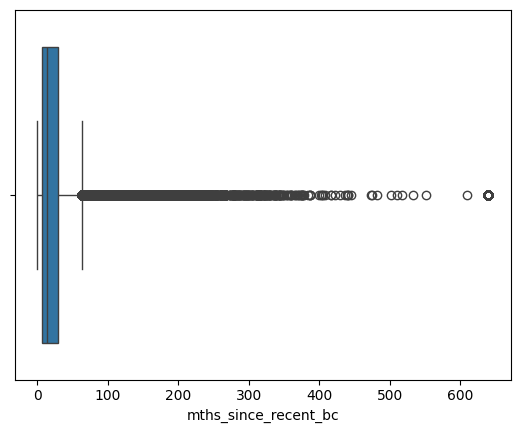

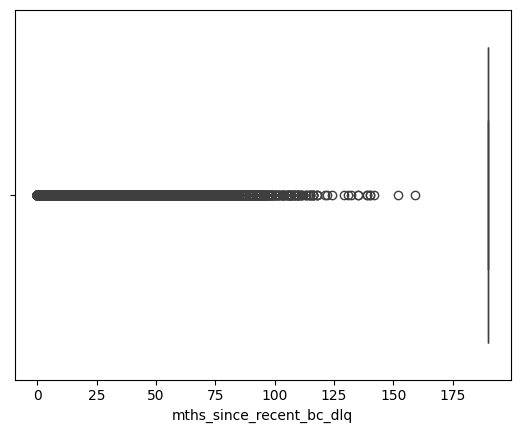

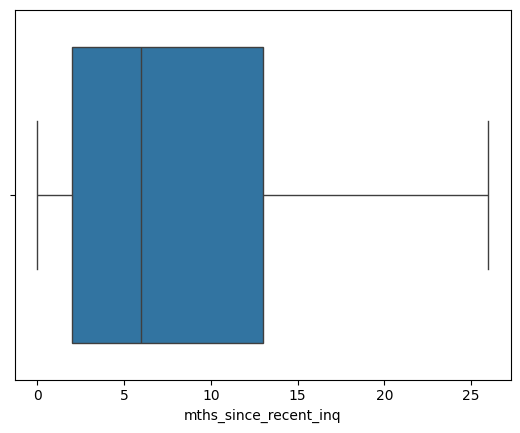

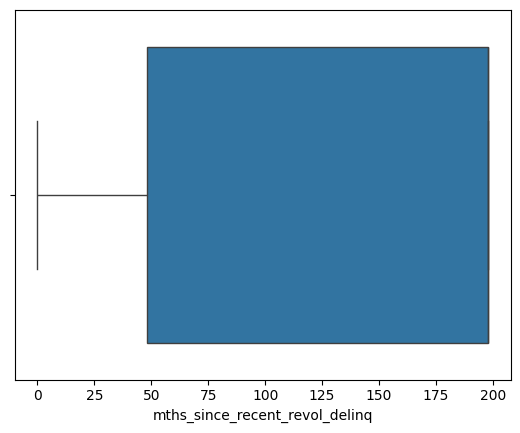

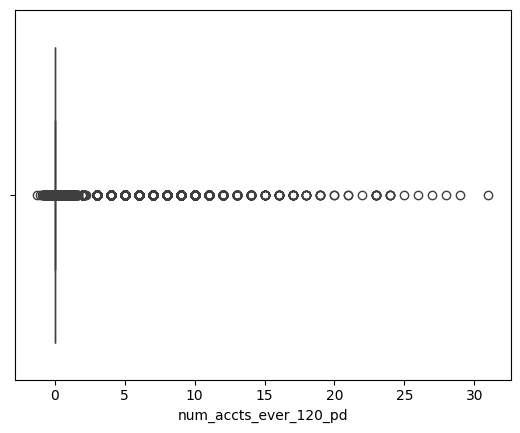

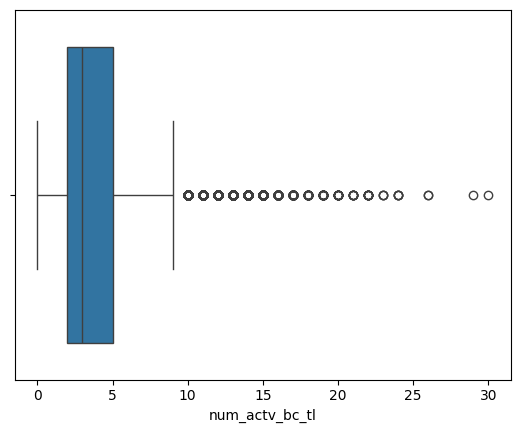

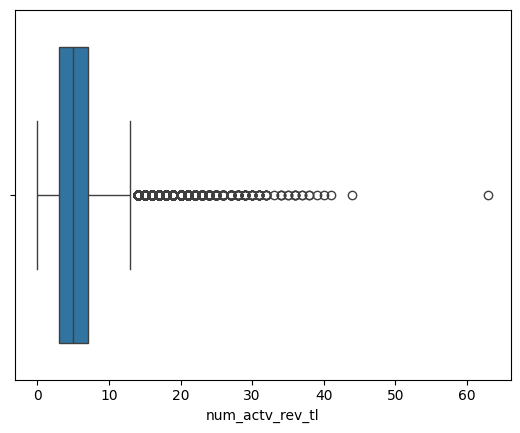

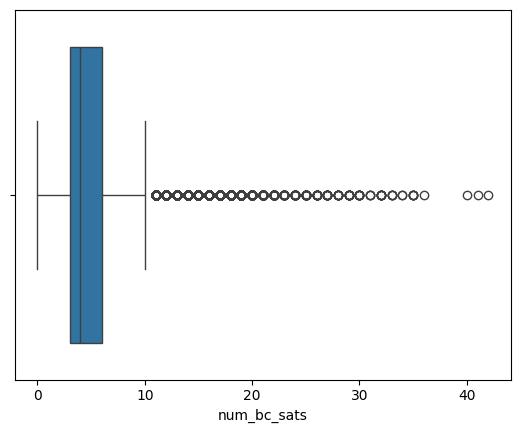

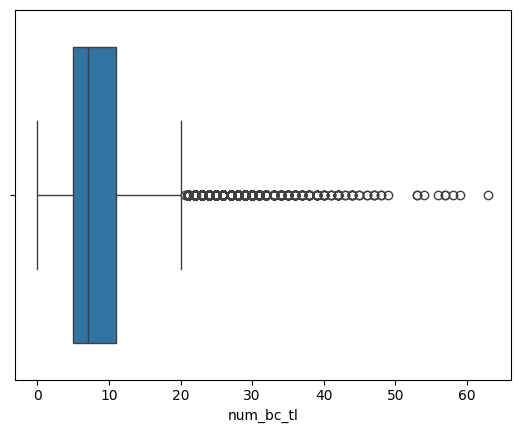

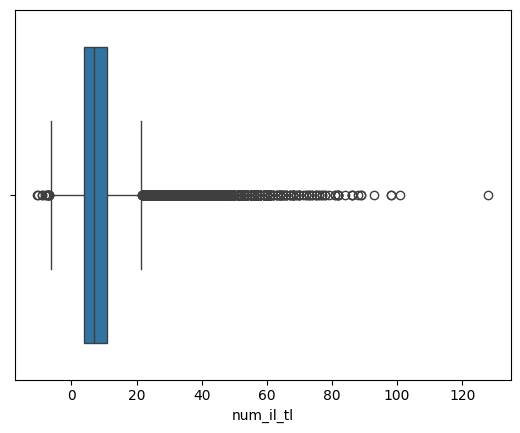

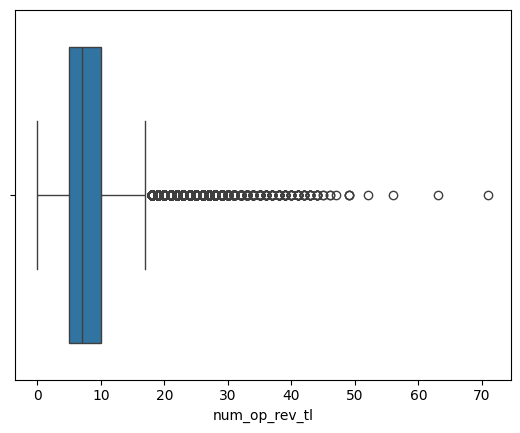

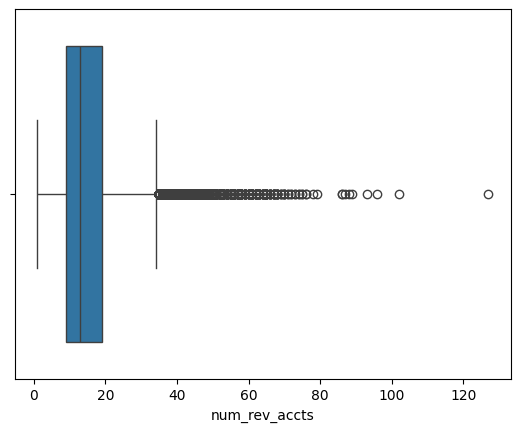

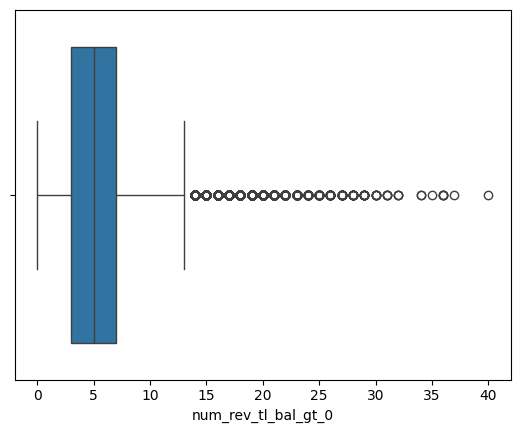

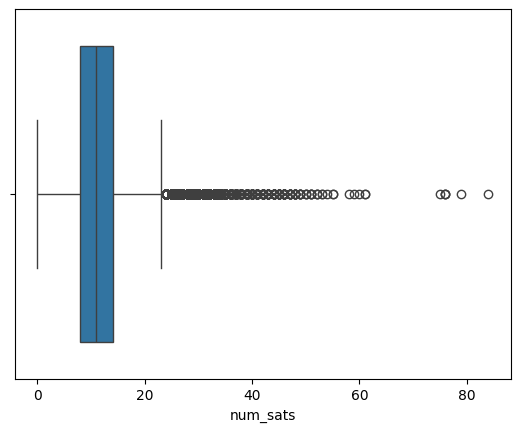

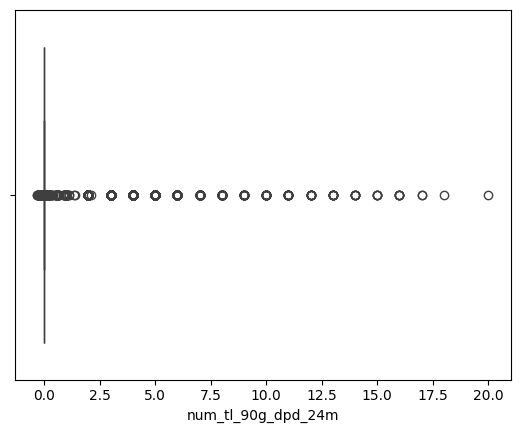

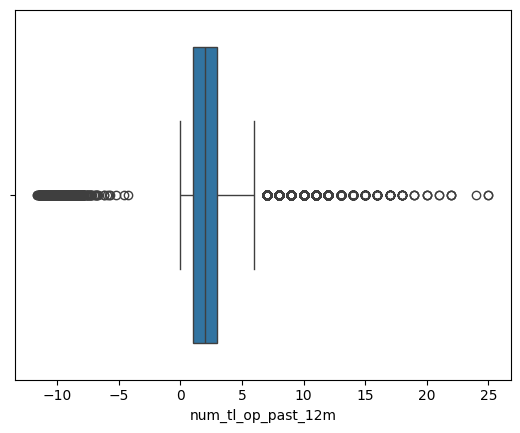

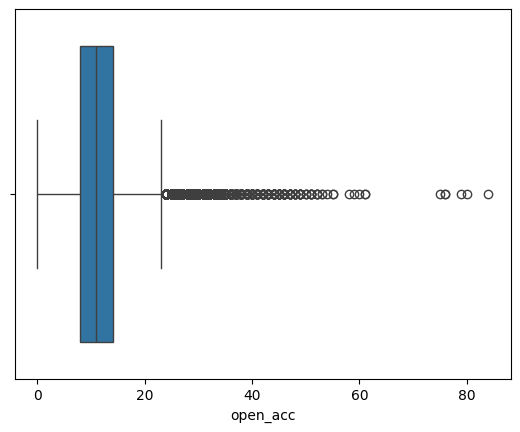

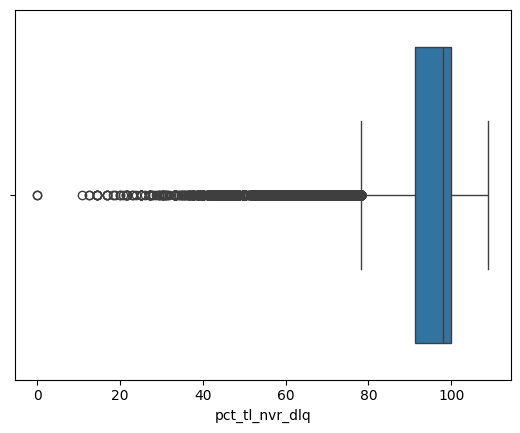

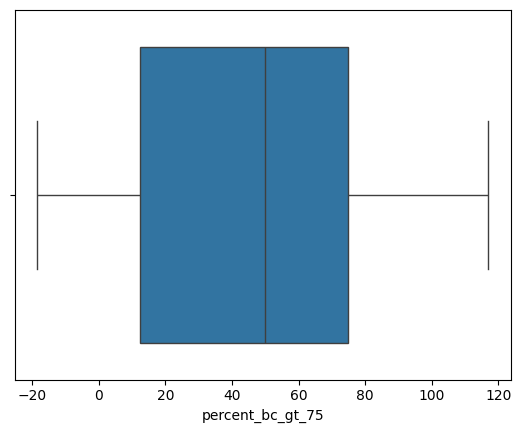

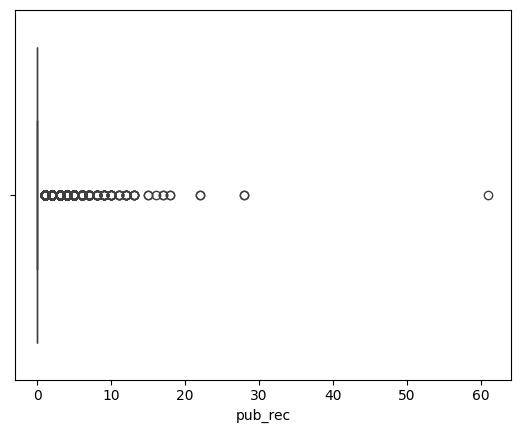

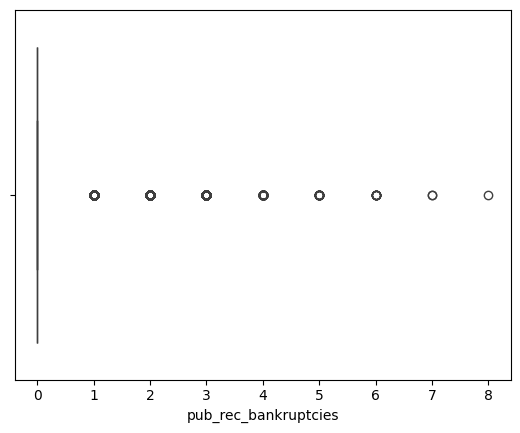

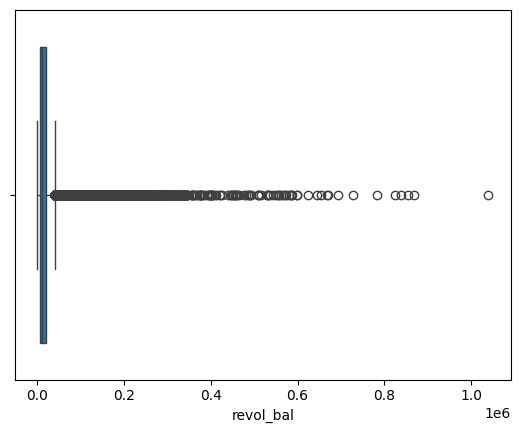

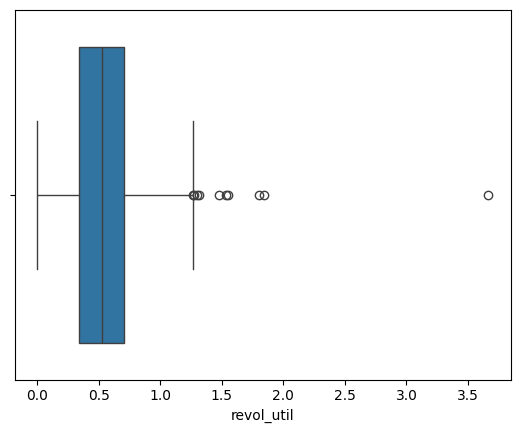

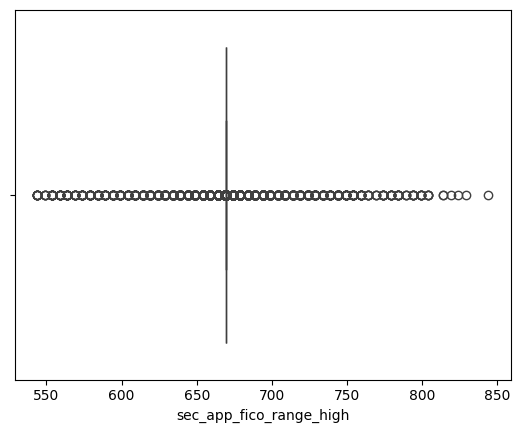

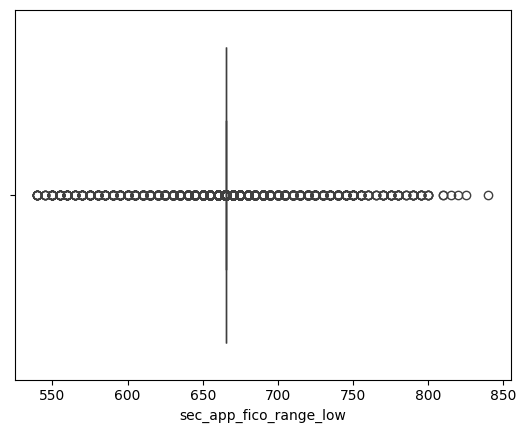

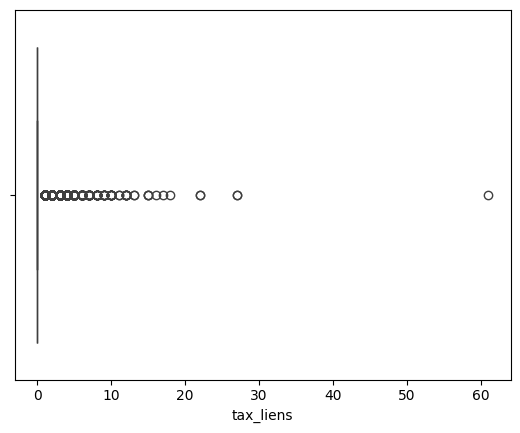

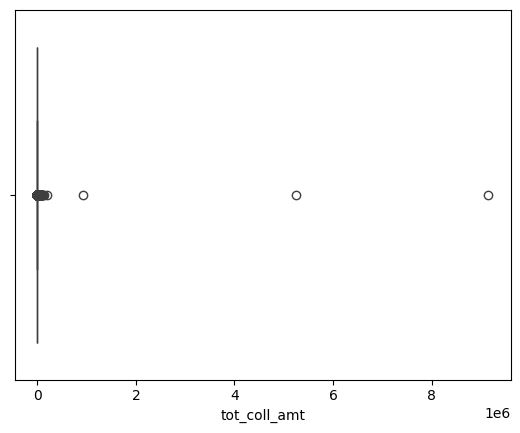

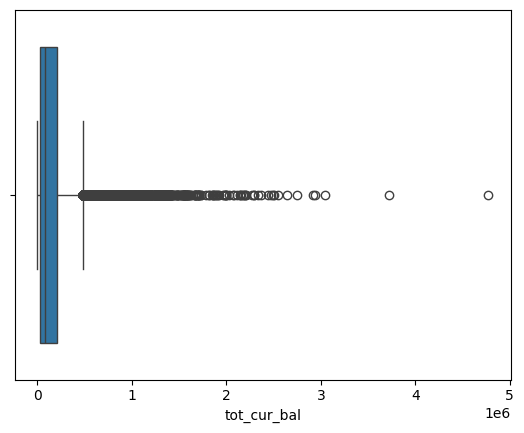

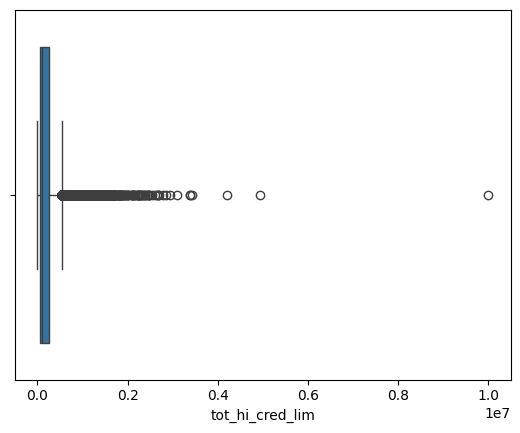

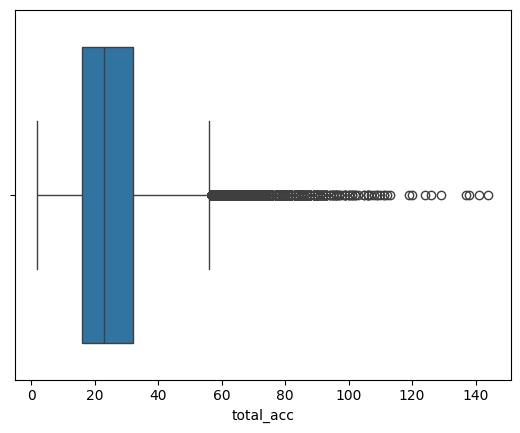

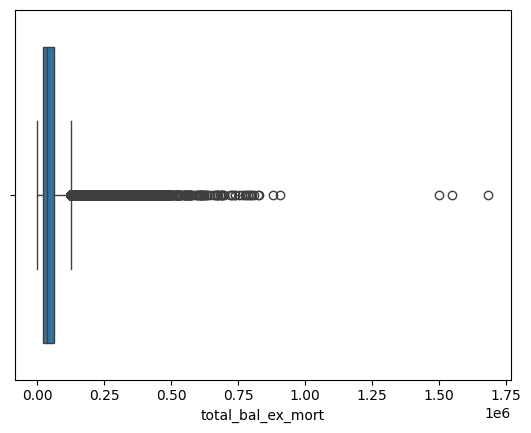

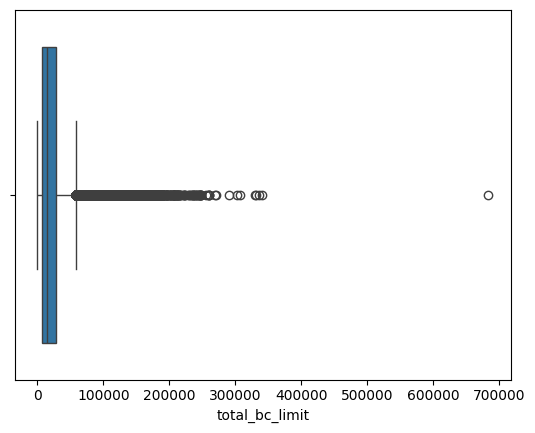

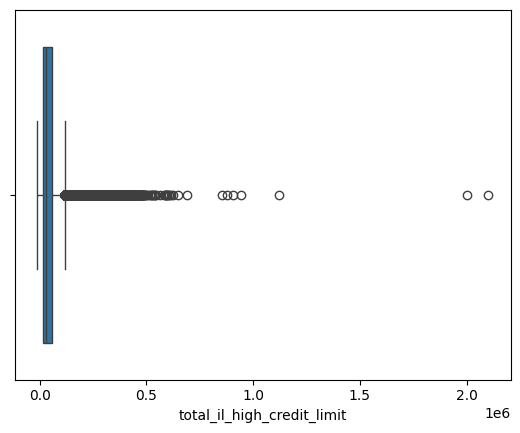

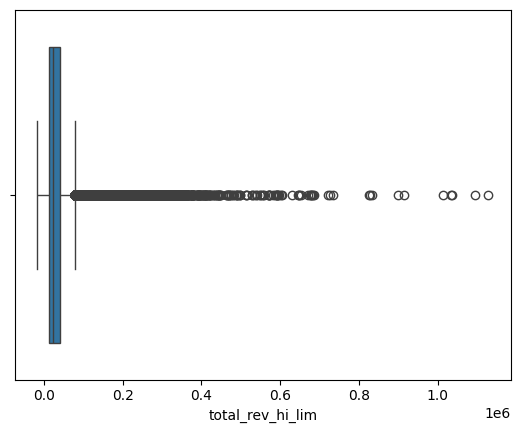

In [7]:
import seaborn as sns
for col in num_cols:
    sns.boxplot(data = loan_df, x = col)
    plt.show()

In [8]:
from scipy.stats import zscore
# Calculate Z-scores
z_scores = num_cols.apply(zscore)

# Filter out rows with any Z-scores > 3 or < -3
num_cols_no_outliers = num_cols[(z_scores < 3).all(axis=1)]
df_no_outliers = pd.concat([num_cols_no_outliers, loan_df.drop(columns=num_cols.columns)], axis=1)
df_no_outliers.dropna(inplace = True)

In [9]:
# Breaking out issue_d to month and year
df_no_outliers['year']=df_no_outliers['issue_d'].dt.year
df_no_outliers['month']=df_no_outliers['issue_d'].dt.month

In [10]:
# Converting some features to categorical for LightGBM
df_no_outliers['addr_state']=df_no_outliers['addr_state'].astype('category')
df_no_outliers['application_type']=df_no_outliers['application_type'].astype('category')
df_no_outliers['emp_length']=df_no_outliers['emp_length'].astype('category')
df_no_outliers['home_ownership']=df_no_outliers['home_ownership'].astype('category')
df_no_outliers['purpose']=df_no_outliers['purpose'].astype('category')
df_no_outliers['verification_status']=df_no_outliers['verification_status'].astype('category')
df_no_outliers['term']=df_no_outliers['term'].astype('category')

In [11]:
# Save model dataframe to a pickle file for easier reading
#df_no_outliers.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')
model_df.to_csv('model_df.csv')

In [84]:
# Count of nulls in each column
null_counts = model_df.isnull().sum()
print(null_counts)

# Check if there are any nulls in the dataframe
has_nulls = model_df.isnull().values.any()
print("Does the dataframe have any nulls?", has_nulls)

acc_now_delinq          0
acc_open_past_24mths    0
annual_inc              0
avg_cur_bal             0
bc_open_to_buy          0
                       ..
purpose                 0
term                    0
verification_status     0
year                    0
month                   0
Length: 101, dtype: int64
Does the dataframe have any nulls? False


# Modeling

## First model: Light Gradient-Boosting Machine

### Using Optuna to find optimal parameters. Focusing on having models with high accuracy

In [12]:
import optuna
import lightgbm as lgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=42)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    #recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy#, recall

In [44]:
'fico_range_low', 'month', 'tot_cur_bal', 'sec_app_fico_range_low', 'last_fico_range_low'

('fico_range_low',
 'month',
 'tot_cur_bal',
 'sec_app_fico_range_low',
 'last_fico_range_low')

### Dropping a ton of columns that didn't really help the model. Call X.columns for final list of features used

In [85]:
X = model_df.drop(columns = ['term','term_ 60 months','emp_length','home_ownership', 'grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d',
'year','purpose_credit_card','purpose_debt_consolidation','purpose_educational','purpose_home_improvement','purpose','application_type_Joint App',
'verification_status_Source Verified','verification_status','addr_state','application_type','pub_rec','tax_liens',
'pub_rec_bankruptcies','num_op_rev_tl','num_sats','total_bal_ex_mort','mo_sin_rcnt_rev_tl_op',
'mths_since_recent_revol_delinq','tot_coll_amt','pct_tl_nvr_dlq','num_rev_accts','num_bc_tl','inq_last_6mths',
'num_bc_sats','open_acc','emp_length_10+ years','emp_length_2-4 years', 'emp_length_5-9 years','purpose_house', 
'purpose_major_purchase', 'purpose_medical','purpose_moving', 'purpose_other', 'purpose_renewable_energy',
'purpose_small_business', 'purpose_vacation', 'purpose_wedding','acc_now_delinq','num_accts_ever_120_pd','delinq_2yrs','chargeoff_within_12_mths',
'collections_12_mths_ex_med','delinq_amnt','mo_sin_old_il_acct','home_ownership_MORTGAGE',
'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN','home_ownership_RENT','fico_range_low', 'month', 'tot_cur_bal', 'sec_app_fico_range_low', 'last_fico_range_low'])
y = model_df['fully_paid']

In [86]:
print(X.columns)
print("Number of columns: ",len(X.columns))

Index(['acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'dti', 'fico_range_high', 'last_fico_range_high',
       'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_last_major_derog',
       'mths_since_last_record', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_il_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75',
       'revol_bal', 'revol_util', 'sec_app_fico_range_high', 'tot_hi_cred_lim',
       'total_acc', 'total_bc_limit', 'total_il_high_credit_limit',
       'total_rev_hi_lim', 'credit_line_age', 'verification_status_Verified'],
      dtype='object')
Number of columns:  35


In [47]:
study = optuna.create_study(directions=['maximize'])
study.optimize(objective, n_trials=100)

[I 2024-12-07 21:16:55,136] A new study created in memory with name: no-name-7d57db46-3e05-45f5-bf19-78df69ddf65d
[I 2024-12-07 21:16:56,512] Trial 0 finished with value: 0.9107244237538322 and parameters: {'lambda_l1': 0.012773771097720517, 'lambda_l2': 0.22853092302963768, 'num_leaves': 192, 'feature_fraction': 0.5146920547184975, 'bagging_fraction': 0.9231846954600972, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 0 with value: 0.9107244237538322.
[I 2024-12-07 21:16:57,502] Trial 1 finished with value: 0.9087941410241853 and parameters: {'lambda_l1': 6.765858888930972e-08, 'lambda_l2': 3.8264390405662286e-08, 'num_leaves': 148, 'feature_fraction': 0.9685066498211722, 'bagging_fraction': 0.4153384719001971, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 0 with value: 0.9107244237538322.
[I 2024-12-07 21:16:58,059] Trial 2 finished with value: 0.9122289088225275 and parameters: {'lambda_l1': 1.749505801448448e-07, 'lambda_l2': 2.88912957922985, 'num_leaves': 

KeyboardInterrupt: 

In [35]:
# Best trial
print(study.best_trial)
trial_params = study.best_trial.params

FrozenTrial(number=68, state=1, values=[0.9133359827410015], datetime_start=datetime.datetime(2024, 12, 7, 20, 45, 8, 225967), datetime_complete=datetime.datetime(2024, 12, 7, 20, 45, 8, 640593), params={'lambda_l1': 7.839517647224522e-08, 'lambda_l2': 0.007146991519920602, 'num_leaves': 32, 'feature_fraction': 0.7542106945466338, 'bagging_fraction': 0.4562193724461856, 'bagging_freq': 7, 'min_child_samples': 66}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, st

In [36]:
trialbst = optuna.trial.Trial(study,32)
trialbst.params

{'lambda_l1': 1.536422753769679e-07,
 'lambda_l2': 0.000283419699214319,
 'num_leaves': 23,
 'feature_fraction': 0.6170990311707734,
 'bagging_fraction': 0.5915951192005495,
 'bagging_freq': 7,
 'min_child_samples': 52}

In [87]:
# First split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

In [88]:
# Further split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=4)  # 20% of train for validation

### These params were found from a previous study, but they worked well. Looking at training/testing accuracy scores as well as the logloss for evaluation

Training accuracy: 0.9165
Validation accuracy: 0.9112
Testing accuracy: 0.9087


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

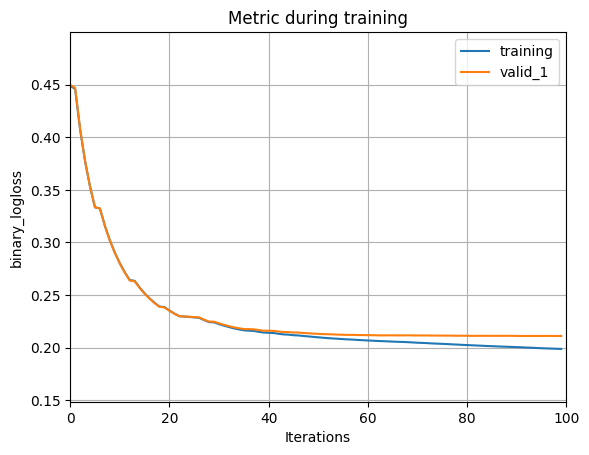

In [76]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Define the model
lgbm = lgb.LGBMClassifier(
    lambda_l1=1.536422753769679e-07,
    lambda_l2=0.000283419699214319,
    num_leaves=23,
    feature_fraction=0.6170990311707734,
    bagging_fraction=0.5915951192005495,
    bagging_freq=7,
    min_child_samples=52,
    random_state=4  # Ensures reproducibility
)

# Fit the model with training and validation datasets
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Use X_val, y_val here
    eval_metric="logloss",  # Metric for binary classification
)

# Display training, validation, and testing accuracy
print('Training accuracy: {:.4f}'.format(lgbm.score(X_train, y_train)))
print('Validation accuracy: {:.4f}'.format(lgbm.score(X_val, y_val)))
print('Testing accuracy: {:.4f}'.format(lgbm.score(X_test, y_test)))

# Retrieve evaluation results
results = lgbm.evals_result_

lgb.plot_metric(lgbm)

## Feature Importance using LightGBM's plot_importance package

                         Feature  Gain Importance
7           last_fico_range_high    143640.374827
8                      loan_amnt      4693.730322
5                            dti      2587.149967
6                fico_range_high      1599.850983
1                     annual_inc      1265.221736
30                total_bc_limit      1182.927977
9           mo_sin_old_rev_tl_op      1020.661035
32              total_rev_hi_lim       993.760310
29                     total_acc       905.565765
33               credit_line_age       808.769488
28               tot_hi_cred_lim       807.254465
25                     revol_bal       797.317118
31    total_il_high_credit_limit       759.045321
3                 bc_open_to_buy       706.713301
4                        bc_util       632.661430
2                    avg_cur_bal       608.143558
26                    revol_util       541.778179
15          mths_since_recent_bc       477.419460
17         mths_since_recent_inq       462.633989


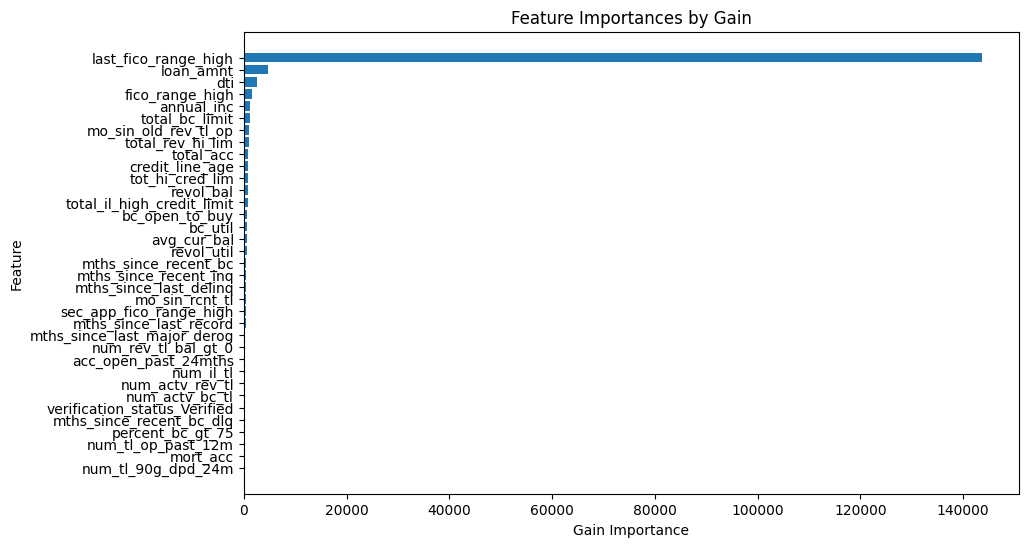

In [77]:
# Get feature importances by gain
feature_importance_gain = lgbm.booster_.feature_importance(importance_type='gain')

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X_train is a DataFrame
    'Gain Importance': feature_importance_gain
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Gain Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Gain Importance'])
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.title('Feature Importances by Gain')
plt.gca().invert_yaxis()  # Flip the order for better readability
plt.show()

# Second model: XGBoost

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Train Accuracy: 0.9123
Validation Accuracy: 0.9118
Test Accuracy: 0.9089


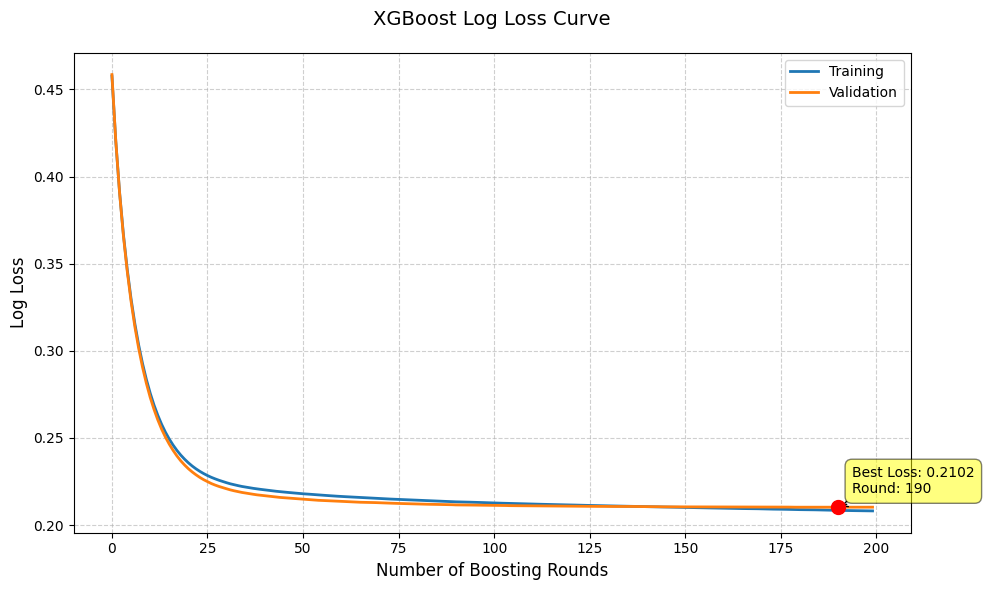

In [89]:
# Initialize the XGBoost classifier with eval_metric
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 10, 20],
    'learning_rate': [0.01, 0.1, 1]
}

# Get best parameters from GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_

# Create a new model with best parameters and eval_set for tracking
final_model = xgb.XGBClassifier(
    **best_params,
    eval_metric='logloss',
    random_state=42
)

# Create evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]

# Fit the model with evaluation set
final_model.fit(
    X_train, 
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Get evaluation results
results = final_model.evals_result()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation curves
plt.plot(range(len(results['validation_0']['logloss'])), 
         results['validation_0']['logloss'], 
         label='Training', 
         linewidth=2)
plt.plot(range(len(results['validation_1']['logloss'])), 
         results['validation_1']['logloss'], 
         label='Validation', 
         linewidth=2)

# Customize the plot
plt.title('XGBoost Log Loss Curve', fontsize=14, pad=20)
plt.xlabel('Number of Boosting Rounds', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.legend(fontsize=10)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Format y-axis to show only 2 decimal places
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Customize tick sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Find and plot the minimum validation loss point
val_loss = results['validation_1']['logloss']
min_val_loss = min(val_loss)
min_val_loss_idx = val_loss.index(min_val_loss)

plt.scatter(min_val_loss_idx, 
           min_val_loss, 
           color='red', 
           s=100, 
           zorder=5)

# Add annotation for minimum point
plt.annotate(f'Best Loss: {min_val_loss:.4f}\nRound: {min_val_loss_idx}',
            xy=(min_val_loss_idx, min_val_loss),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adjust layout
plt.tight_layout()

# Print accuracies
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Best Hyperparameters:", best_params)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

plt.show()


## Feature Importance of XGBoost model

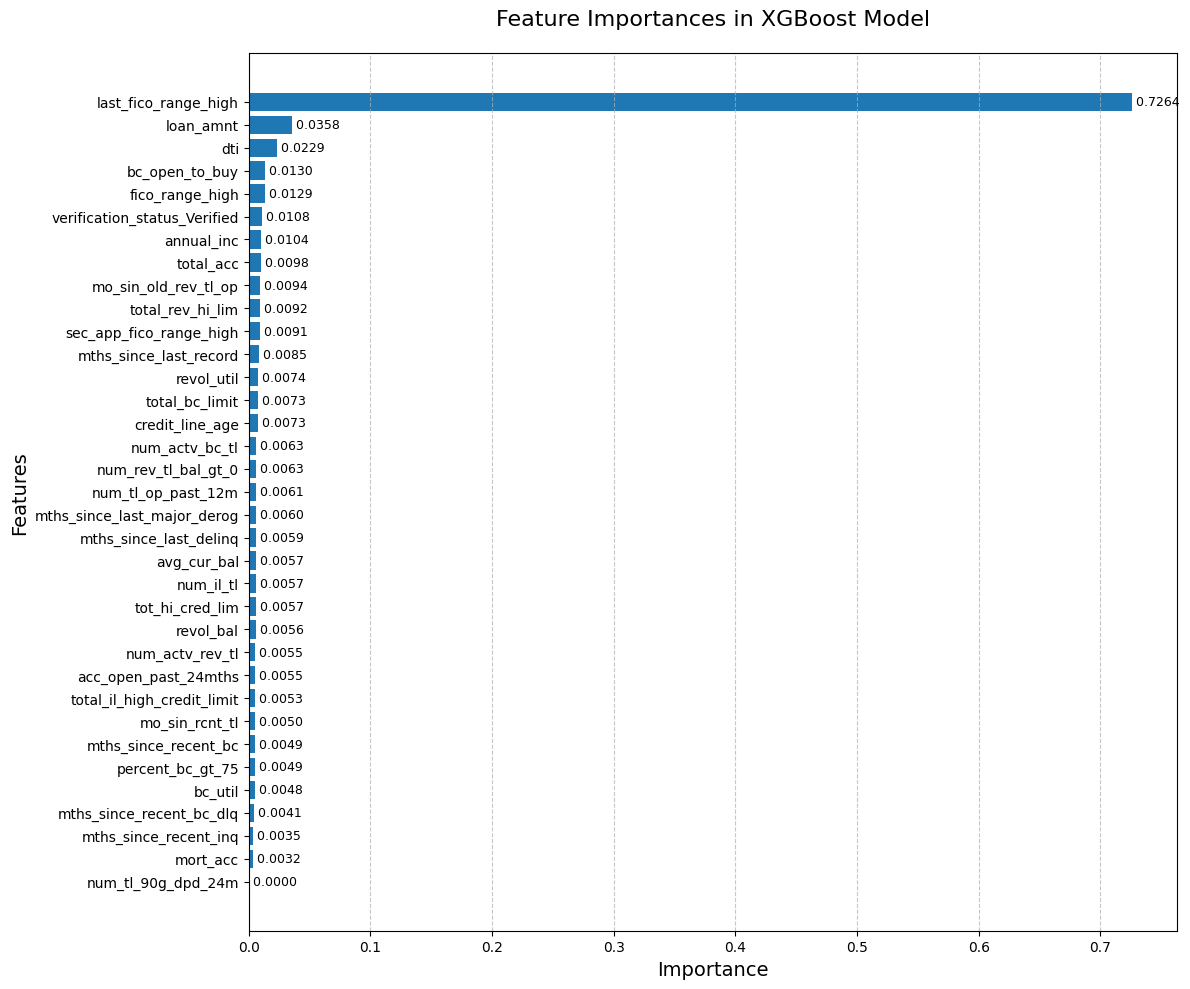

In [90]:
# Get feature importances
importances = final_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)

# Get feature names (assuming X_train is a DataFrame, otherwise use range(len(importances)))
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]

# Create plot
plt.figure(figsize=(12, 10))
plt.title("Feature Importances in XGBoost Model", fontsize=16, pad=20)
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [feature_names[i] for i in indices], fontsize=10)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Add value labels at the end of each bar
for i, v in enumerate(importances[indices]):
    plt.text(v, i, f" {v:.4f}", va='center', fontsize=9)

# Customize the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

## Partial Dependency Plots

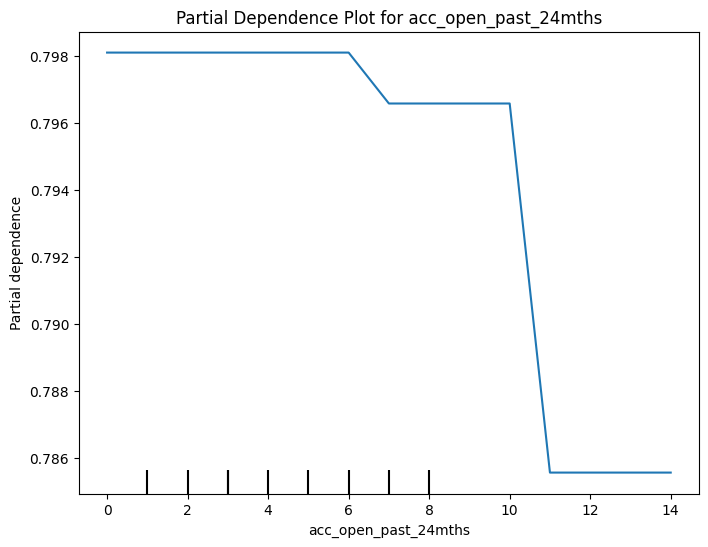

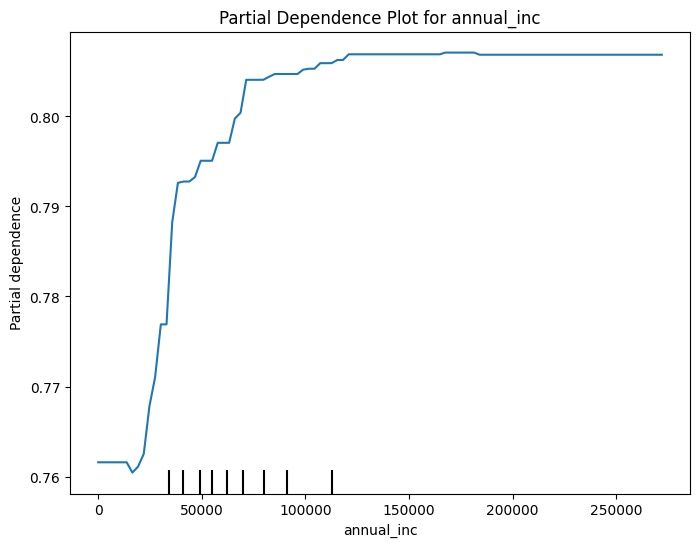

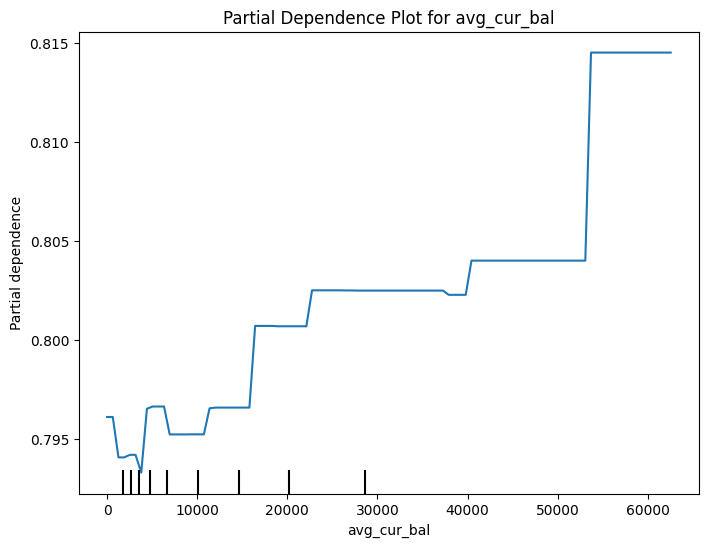

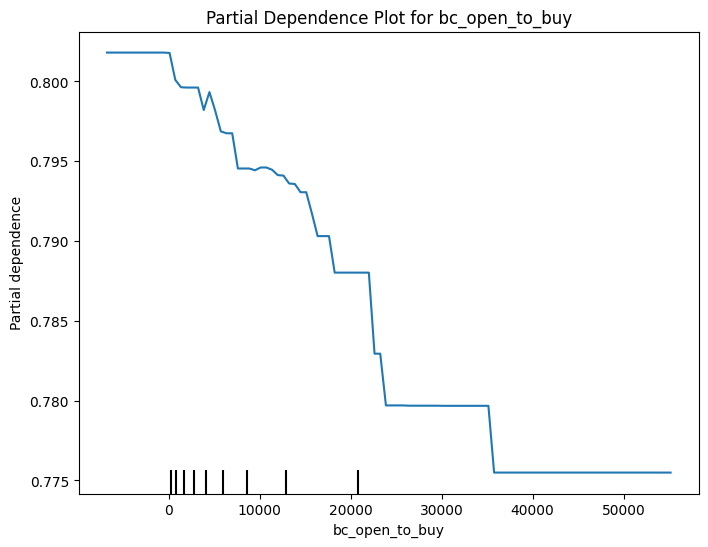

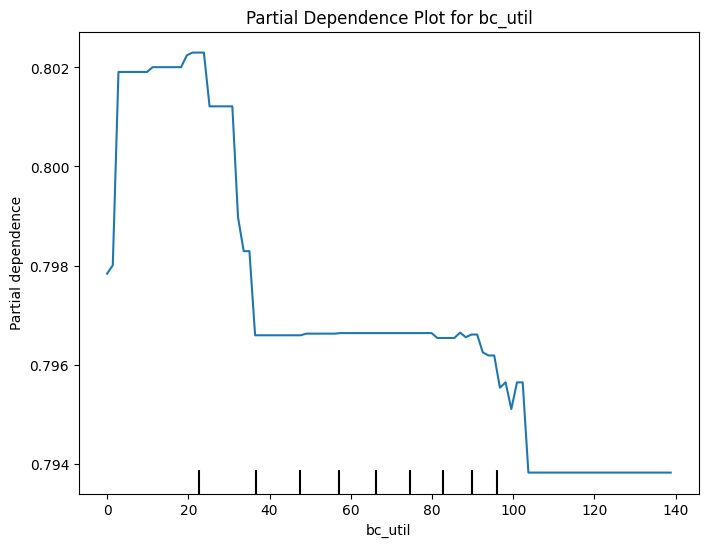

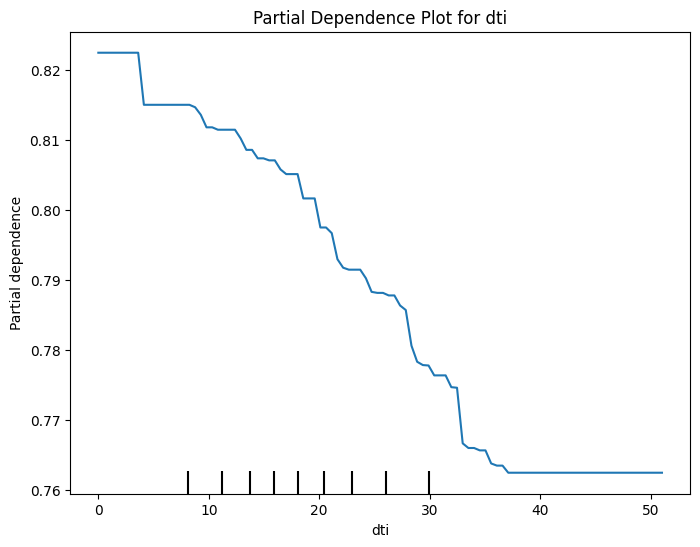

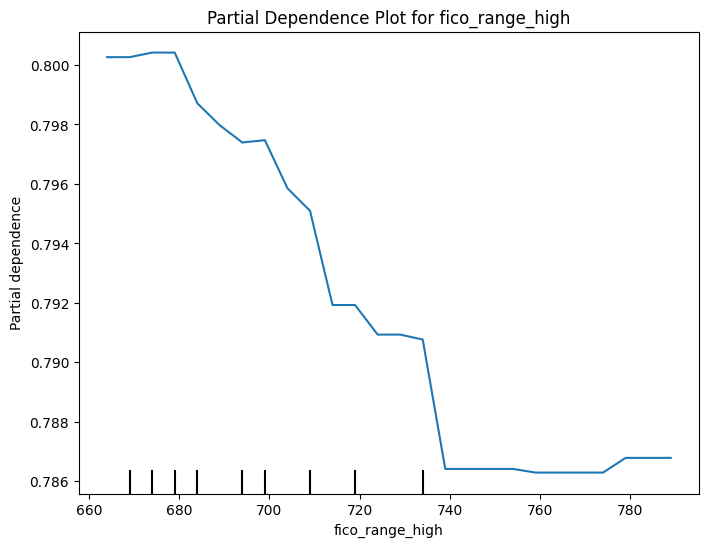

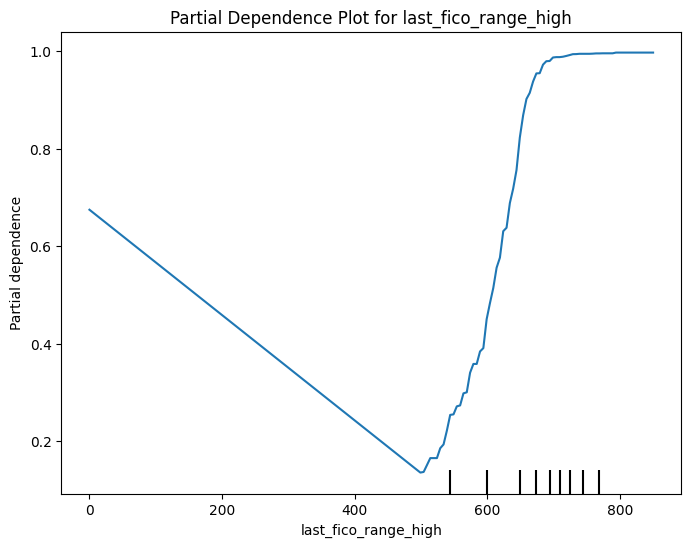

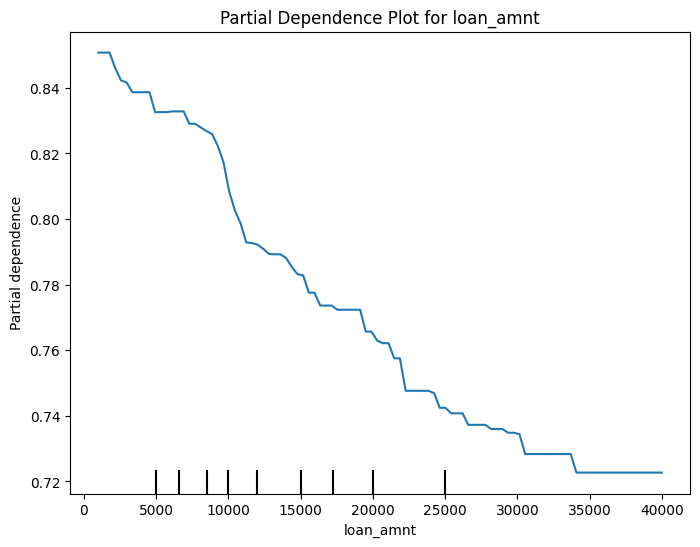

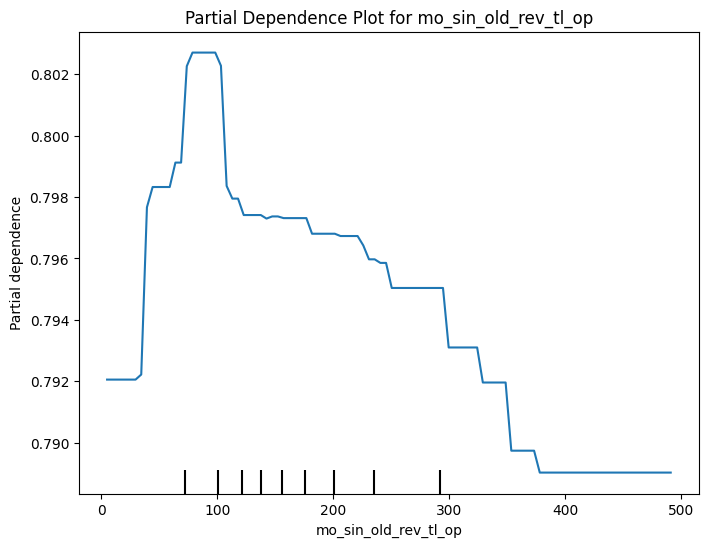

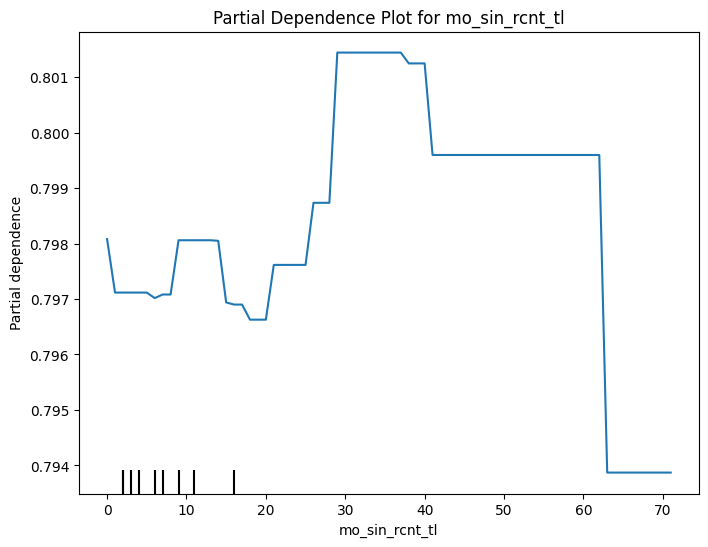

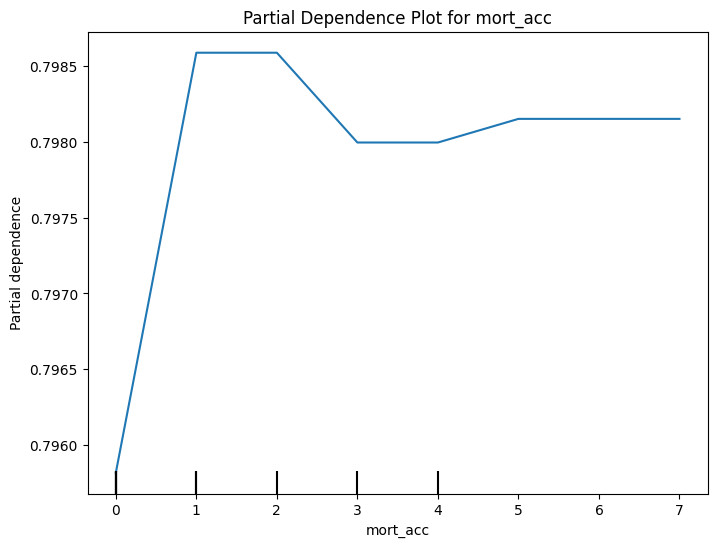

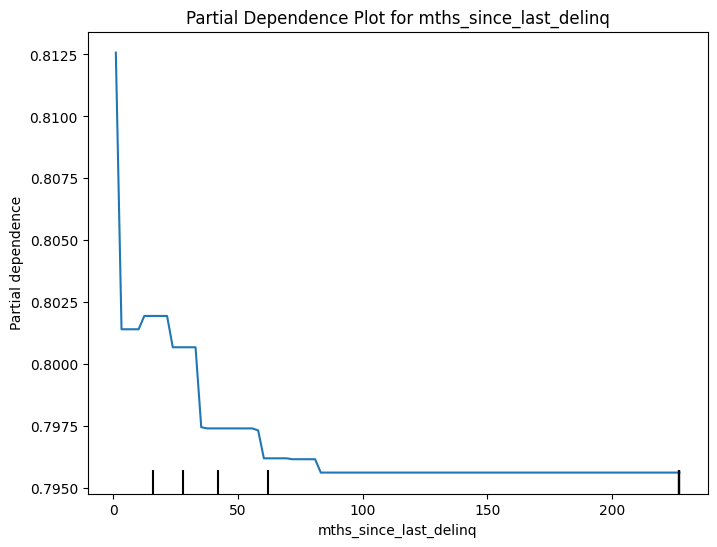

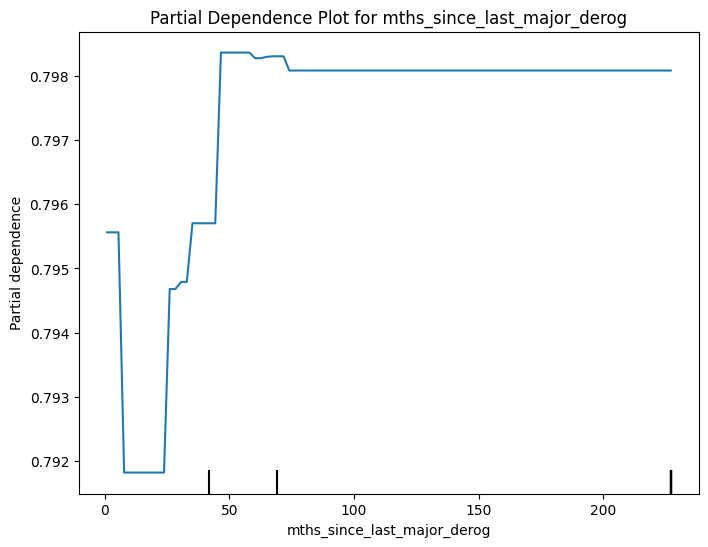

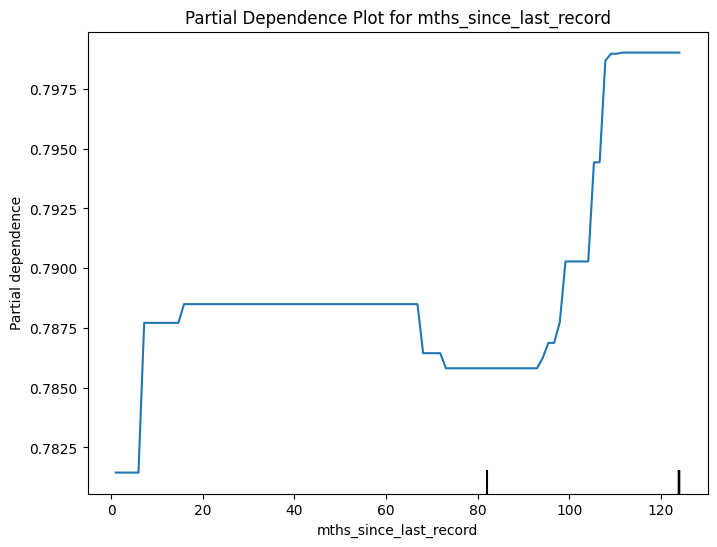

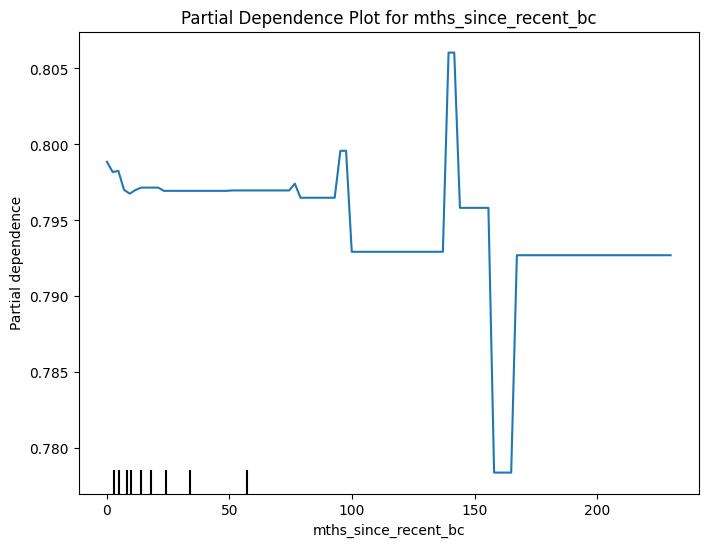

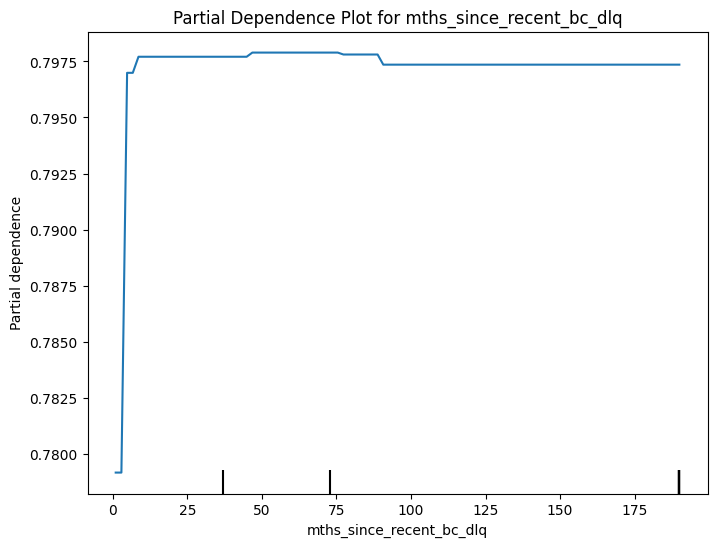

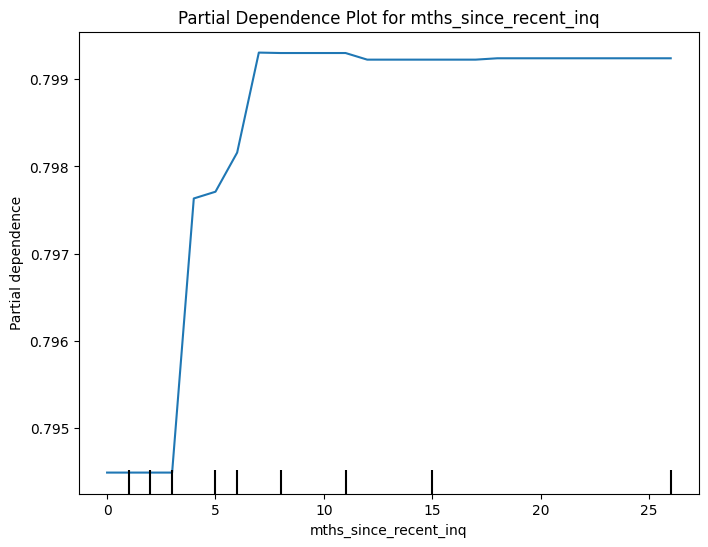

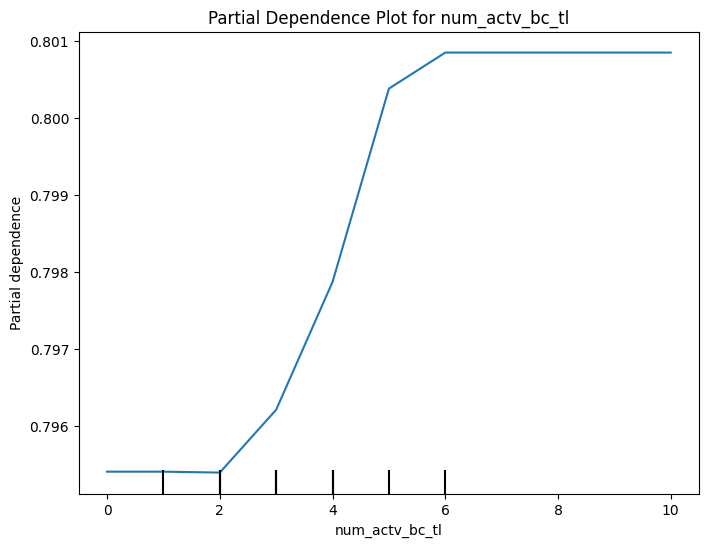

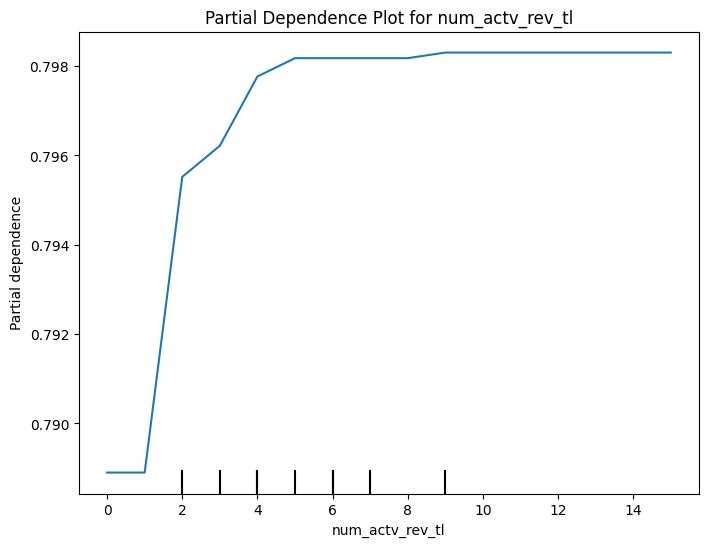

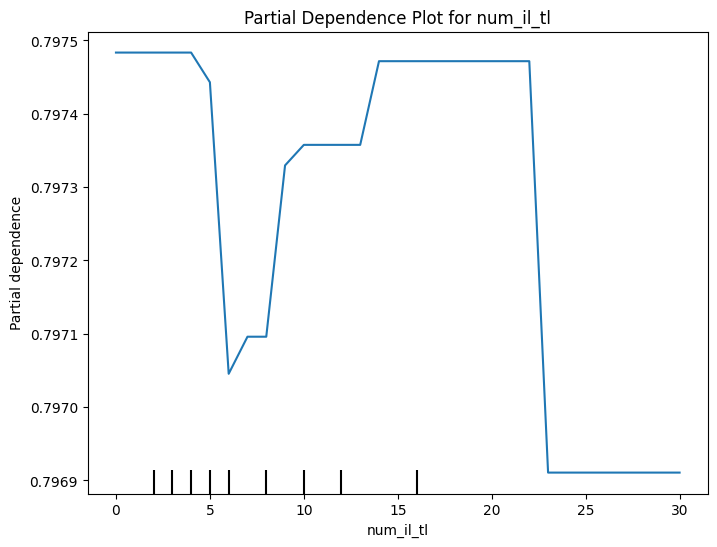

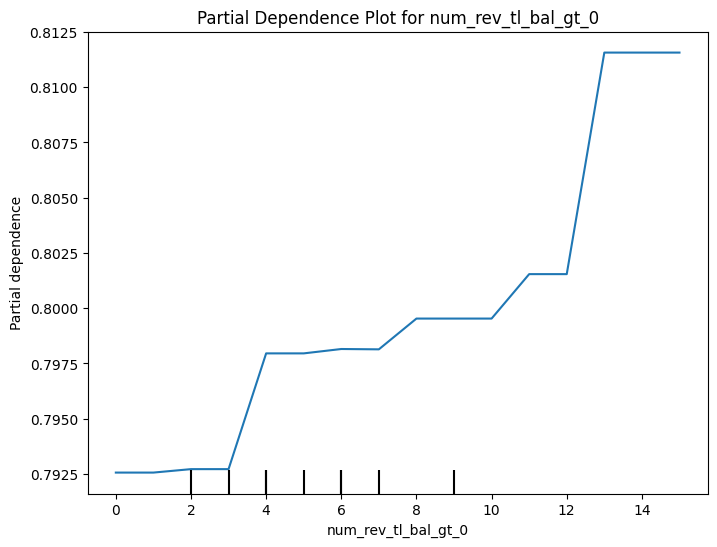

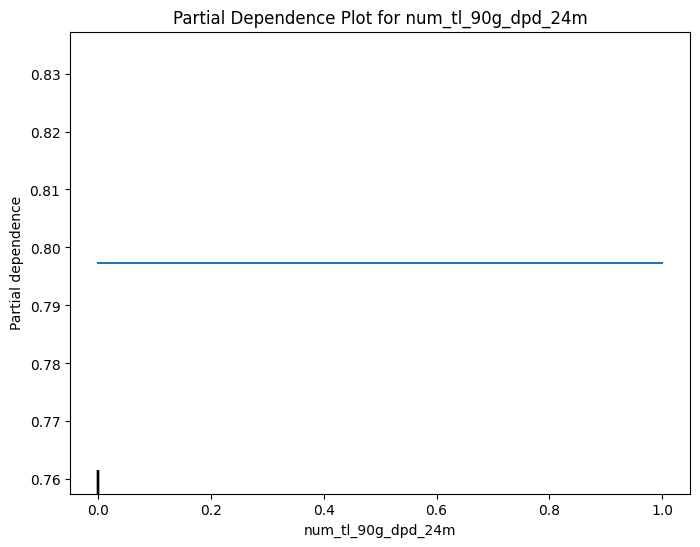

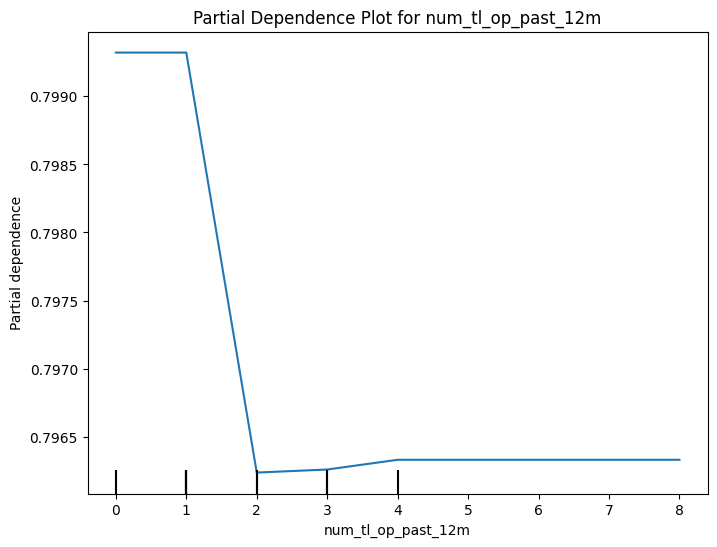

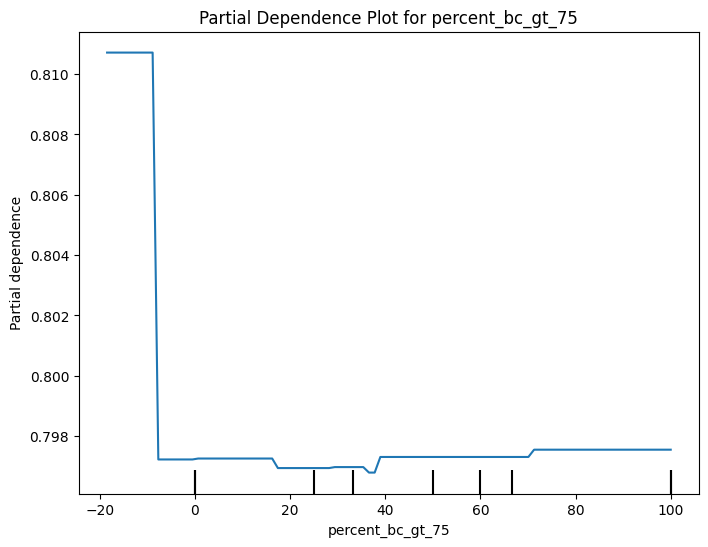

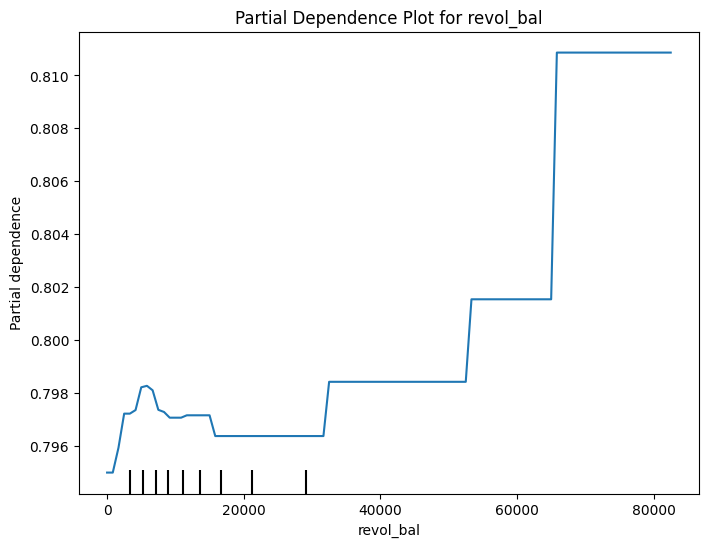

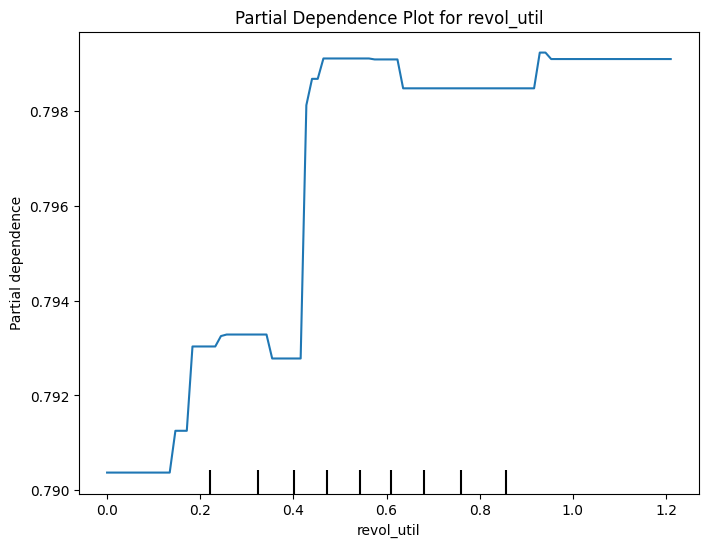

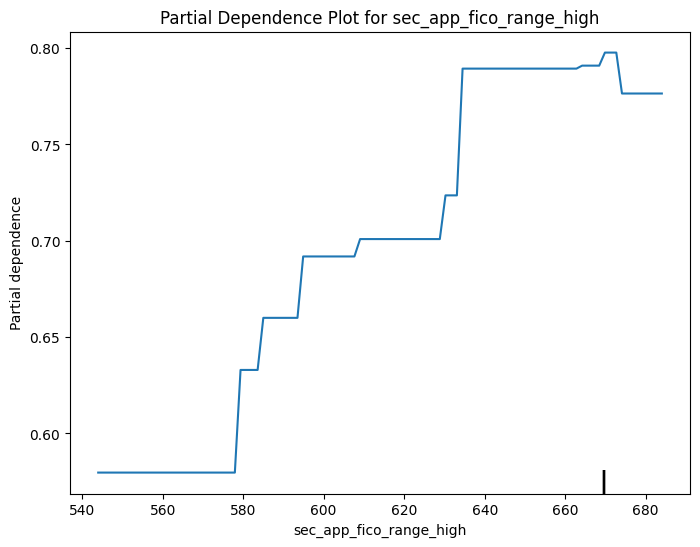

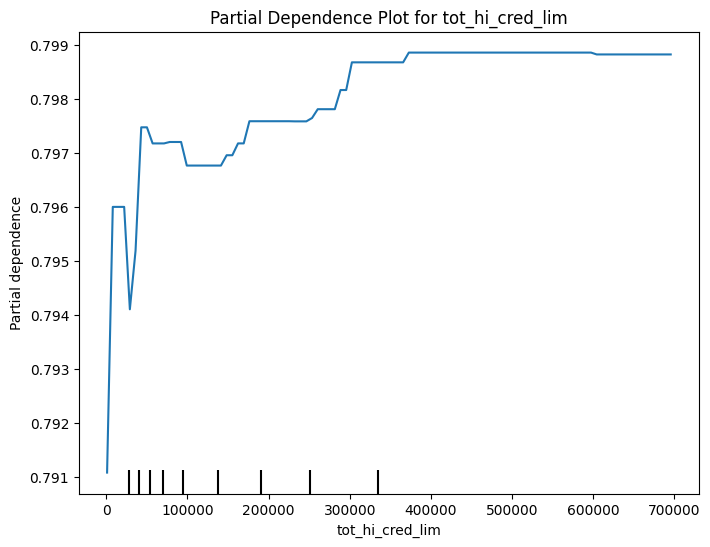

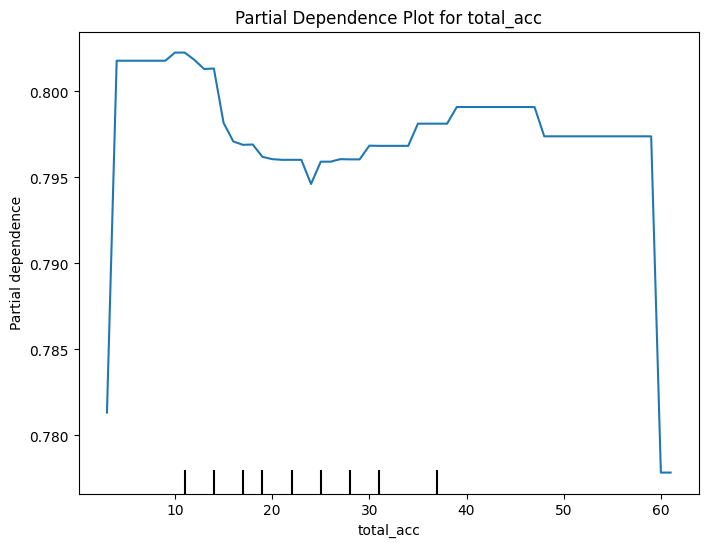

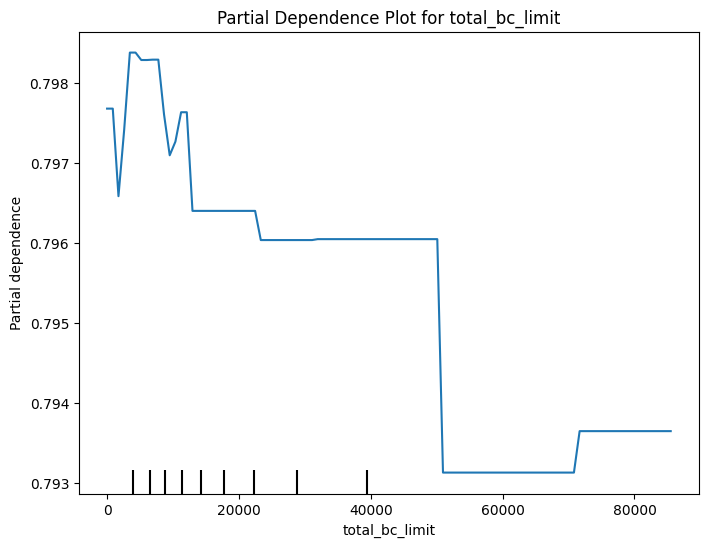

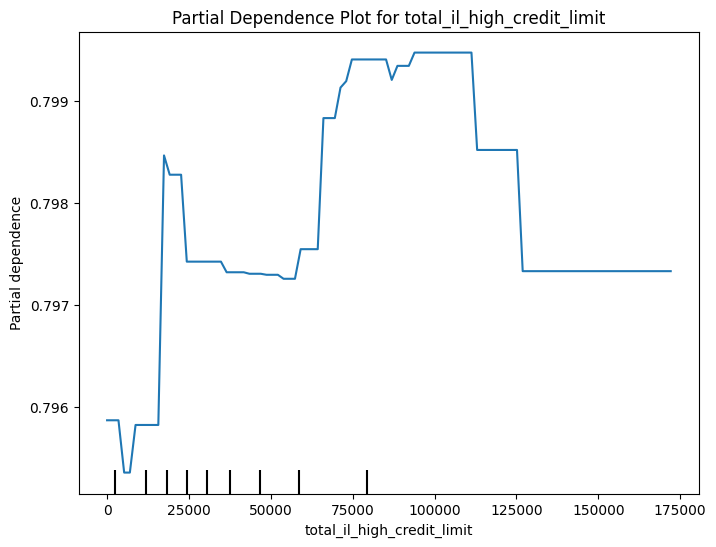

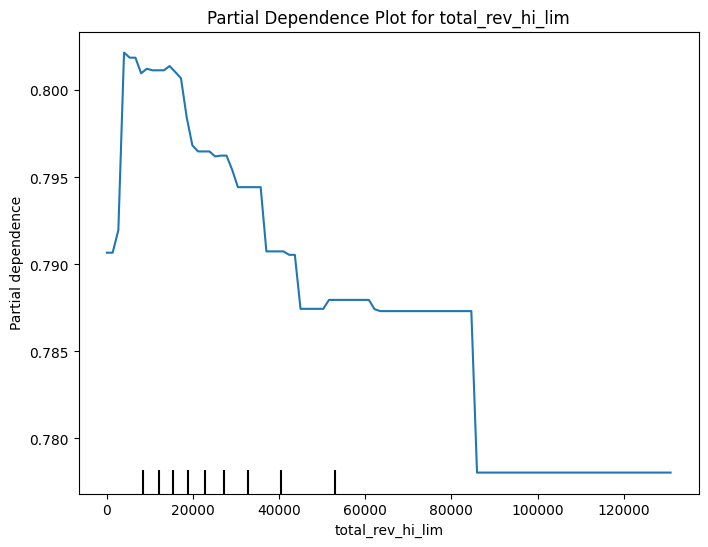

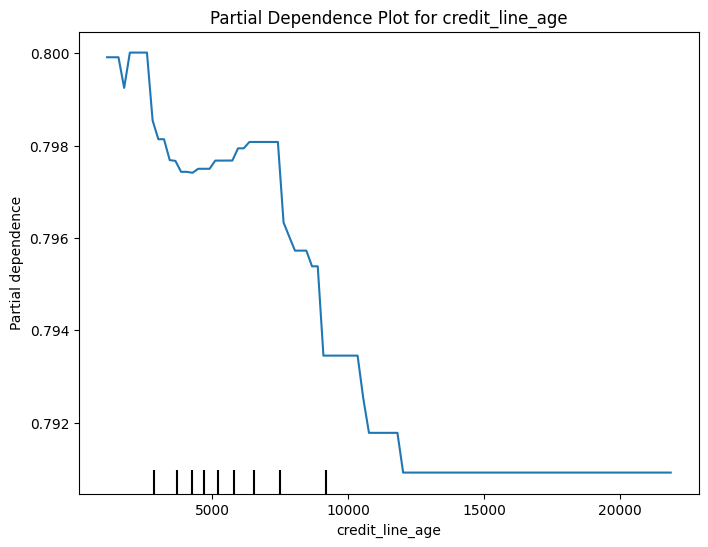

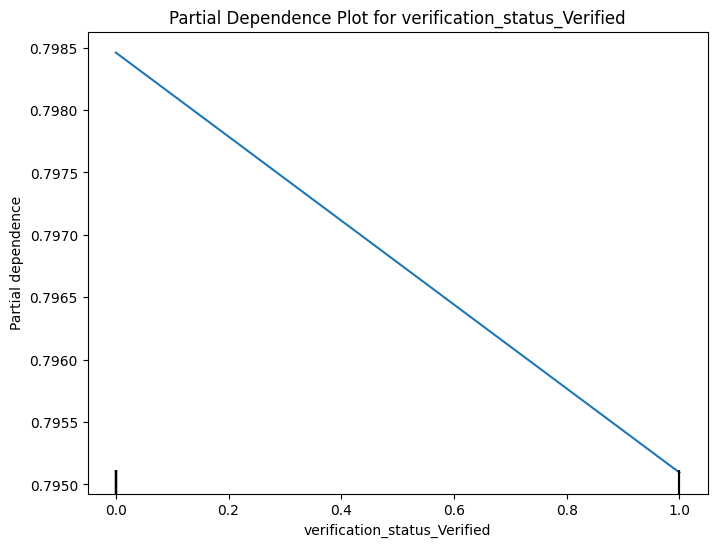

In [91]:
from sklearn.inspection import PartialDependenceDisplay
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=final_model,
        X=X_train,
        features=[feature],
        kind="average",  # Change to 'both' to include ICE curves
        percentiles = (0,1),
        ax=plt.gca(),
    )
    plt.title(f"Partial Dependence Plot for {feature}")
    plt.show()